# 01. A Very Simple Agent

Welcome to the first notebook of this series! This course guides you on how to develop Agentic AI workflows, from theory to practice, and highlights key ideas and concepts required to develop production-ready AI applications. 

But what is Agentic AI? In simple terms, agents are language models (such as GPT, Claude, etc.) with tools and memory. Let's break this down. 
**Agents = LLMs + Tools + Memory:**
- **LLM** provides reasoning, planning, and language understanding/production.
- **Tools** extend capability (e.g., calculator, web fetcher, code runner, database query). Think *actuators* or *APIs* that the LLM can call.
- **Memory** gives *state* across turns (short‑term scratchpad and/or long‑term profile/knowledge).

### Why agents?
- Pure LLMs can sound smart but hallucinate or lack real‑world actions.
- With tools, the model can check facts, run code, or retrieve data instead of guessing.
- With memory, it becomes context‑aware across sessions and tasks.

Other benefits include modularity, ability to parallize tasks with multiple agents and much better performance compared to non-agentic systems.

Although this course does not require the reader to know the details of how LLMs work, if you are interested to know, feel free to check out [LLMs from Scratch](https://shreshthtuli.github.io/llms-from-scratch/). LLMs act as the "brain" in agentic systems, which are also referred to as "workflows" because there may be constant back-and-forth across multiple LLMs, tool calls and memory state updates. There is an entire spectrum of autonomy that that we can give these LLMs, from being less autonomous - having hardcoded workflow of tool and memory use - to more autonomous, where the LLM decides which tool to use and how. See the examples for an agent that researches for a given topic and provides as essay below to highlight the two ends of this spectrum.

![image](assets/degrees-of-autonomy.png)

I recommend watching [Andrew Ng's Lecture on Agentic AI](https://learn.deeplearning.ai/courses/agentic-ai/lesson/zqs9ty/degrees-of-autonomy).

However, this required typical LLMs to be very precise in terms of the *structure of outputs* that they produce. It is not as straightforward as it sounds. Let' see this using [OpenRouter](https://openrouter.ai/), which is a unified interface to call all LLMs. 

> Make sure to populate the `.env` file with the required keys. 

## Structured Outputs

Structured outputs turn an LLM’s free-form text into **machine-readable actions**, which is the foundation of any reliable agent. Here’s why they matter:

* **Deterministic control** → Agents must make decisions, not poetry. Structured schemas (JSON, Pydantic models) enforce predictable formats.
* **Tool interoperability** → Tools, APIs, databases, and other agents expect **typed fields**, not paragraphs.
* **Error catching** → Validation instantly flags missing or malformed fields, preventing silent failures.
* **Multi-step reasoning** → Complex agent pipelines (planning → acting → reflecting) need **cleanly structured state** passed between steps.
* **Safety & alignment** → Structure reduces hallucinations by constraining what the model can output.

In short: **no structure → no reliable agents.** Structured outputs are the contract that turns an LLM into a **real, programmable, dependable agent.**


In [1]:
from openai import OpenAI
from dotenv import load_dotenv
import os

load_dotenv()

client = OpenAI(
  base_url="https://openrouter.ai/api/v1",
  api_key=os.getenv("OPENROUTER_API_KEY"),
)

completion = client.chat.completions.create(
  model="qwen/qwen-2.5-7b-instruct",
  messages=[
    {
      "role": "user",
      "content": "What is the meaning of life?"
    }
  ]
)

print(completion.choices[0].message.content)

The meaning of life is a question that has puzzled philosophers, thinkers, and common people throughout history. It's often considered one of the most profound and personal questions an individual can ask.

While there is no singular answer that applies to everyone, many people find their own personal meaning in life through various avenues such as:

1. **Personal Fulfillment:** Finding joy in hobbies, work, relationships, and achieving personal goals.
2. **Service:** Contributing positively to society or helping others.
3. **Exploration:** Learning about the world and different cultures.
4. **Love:** Cherishing and nurturing deep emotional connections.
5. **Philosophy:** Reflecting on deeper existential questions and the nature of reality.
6. **Spirituality:** Believing in a higher power or finding inner peace.
7. **Science and Creativity:** Contributing to intellectual and artistic endeavors.

Ultimately, the meaning of life can be very personal and will differ from person to person.

Probably too deep a question to be the first prompt for the course :p.

Let's try to generate a structured response now. 

We shall use [Pydantic](https://docs.pydantic.dev/2.12/) data validation library to create models/schemas for structured outputs and validate responses with set schemas. For example, a `BaseModel` object has a JSON schema as follows. 

In [8]:
from pydantic import BaseModel, Field

class Itinerary(BaseModel):
    city: str = Field(description="city name")
    days: int = Field(description="number of days in that city")
    highlights: list[str] = Field(description="things to do")

Itinerary.model_json_schema()

{'properties': {'city': {'description': 'city name',
   'title': 'City',
   'type': 'string'},
  'days': {'description': 'number of days in that city',
   'title': 'Days',
   'type': 'integer'},
  'highlights': {'description': 'things to do',
   'items': {'type': 'string'},
   'title': 'Highlights',
   'type': 'array'}},
 'required': ['city', 'days', 'highlights'],
 'title': 'Itinerary',
 'type': 'object'}

We use the `model_validate_json()` method of the `BaseModel` object to check and generate an `Itinerary` object.

In [28]:
def get_example_itinerary(model):
    completion = client.chat.completions.create(
    model=model,
    messages=[
        {
        "role": "user",
        "content": f"Give an example Itinerary as a json object with the schema: {Itinerary.model_json_schema()} and nothing else."
        }
    ]
    )
    return completion.choices[0].message.content

qwen_response = get_example_itinerary('qwen/qwen-2.5-7b-instruct')
gpt_response = get_example_itinerary('openai/gpt-oss-20b:free')
print("Qwen 2.5 Response:\n", qwen_response)
print("GPT OSS Response:\n", gpt_response)

Qwen 2.5 Response:
 {
  "city": "Paris",
  "days": 3,
  "highlights": [
    "Eiffel Tower",
    "Louvre Museum",
    "Notre-Dame Cathedral",
    "Montmartre Hill",
    "Seine River Cruise"
  ]
}
GPT OSS Response:
 {"city":"Paris","days":5,"highlights":["Eiffel Tower","Louvre Museum","Seine River Cruise"]}


Let's see if this works. 

In [26]:
Itinerary.model_validate_json(qwen_response)

ValidationError: 1 validation error for Itinerary
  Invalid JSON: expected value at line 1 column 1 [type=json_invalid, input_value='```json\n{\n  "city": "N...ow ticket"\n  ]\n}\n```', input_type=str]
    For further information visit https://errors.pydantic.dev/2.12/v/json_invalid

Clearly, Qwen 2.5 model response is not as per the required format. This is because Qwen 2.5 models weren't tuned for structured responses.

In [27]:
Itinerary.model_validate_json(gpt_response)

Itinerary(city='Paris', days=3, highlights=['Visit Eiffel Tower', 'Explore Louvre Museum', 'Stroll along Seine River'])

GPT OSS models, on the other hand, have been tuned to provide structured responses. Although, there are workaronuds to this, such as using reflection and other concepts (we discuss these in a future tutorial), but for now we shall use models that are tuned to give structured outputs. Another thing we can do, is to explicitly provide a response format in the API call. 

The way this works is called **constrained decoding**. The core mechanism for enforcement is constrained decoding. Instead of letting the model generate tokens freely, the API dynamically validates each token generated against the provided JSON schema. If a generated token would lead to an output that violates the schema, the model is prevented from generating it, and the generation process is guided towards valid tokens. This ensures that the final output strictly adheres to the defined structure.

Reference: [HuggingFace Docs](https://huggingface.co/docs/inference-providers/en/guides/structured-output).

In [31]:
response_format = {
    "type": "json_schema",
    "json_schema": {
        "name": "Itinerary",
        "schema": Itinerary.model_json_schema(),
        "strict": True,
    },
}

def get_example_itinerary_enforced(model):
    completion = client.chat.completions.create(
    model=model,
    response_format=response_format,
    messages=[
        {
        "role": "user",
        "content": f"Give an example Itinerary as a json object with the schema: {Itinerary.model_json_schema()} and nothing else."
        }
    ]
    )
    return completion.choices[0].message.content

qwen_response = get_example_itinerary('qwen/qwen-2.5-7b-instruct')
gpt_response = get_example_itinerary('openai/gpt-oss-20b:free')

print(Itinerary.model_validate_json(qwen_response))
print(Itinerary.model_validate_json(gpt_response))

city='Paris, France' days=3 highlights=['Visit the Eiffel Tower', 'Explore the Louvre Museum', 'Stroll through the Champs-Élysées', 'Dine at a French bistro', 'Experience a Seine River cruise']
city='Paris' days=5 highlights=['Eiffel Tower', 'Louvre Museum', 'Notre-Dame Cathedral', 'Seine River Cruise', 'Montmartre']


## A Very Simple Agent

Now that we've seen how to generate structured responses, let's build a very simple agent that sorts given lists. We will use [Bubble Sort](https://en.wikipedia.org/wiki/Bubble_sort) like sorting in this example and show how a non-agentic system dwarfs in comparison to an agentic system. 

### 🧩 Step 1: Define Agentic Building Blocks

In this section, we define the **core components** of our agentic sorting framework using **Pydantic** for structured reasoning and memory management.

1. LLMResponse — Structured Output Format
This defines how the LLM communicates with the environment:
- `thought`: natural language reasoning or explanation of the next action.
- `swaps`: a list of index pairs `(i, j)` representing swap operations the agent wants to perform this step.  
  *(Multiple swaps can be proposed; they will be applied sequentially, so later indices may change after earlier swaps.)*
- `final_answer`: the sorted list, returned when the agent decides the task is complete.

2. AgentState — Persistent Memory
Stores the agent’s internal state across steps:
- `current_list`: the current working list of numbers.
- `last_swap`: the most recent swap pair.
- `did_swap_last_step`: boolean flag to track if a swap occurred.
- `last_swap_message`: concatenated messages describing recent swaps.
- `step` and `max_steps`: iteration counters and safety limits.

3. binary_swap Tool — Environment Action
    A simple deterministic operation that:
    - Compares values at indices `i` and `j`.  
    - Swaps them if they are out of order.  
    - Returns a message describing what happened (used for traceability and feedback).

Together, these three components form the **foundation of an agentic loop**:
> **LLM → proposes swaps → tool executes swaps → memory updates → LLM observes new state**

In [45]:
from typing import List, Optional, Tuple, Dict, Any
from pydantic import BaseModel, Field

# ---------- Response format (Pydantic) ----------
class LLMResponse(BaseModel):
    thought: str
    swaps: Optional[List[Tuple[int, int]]] = None # example: [[1, 2], [0, 1], [4, 9]]
    final_answer: Optional[List[int]] = None     # only one or the other is used

# ---------- Agent Memory (Pydantic) ----------
class AgentState(BaseModel):
    current_list: List[int]
    last_swap: Optional[Tuple[int, int]] = None
    did_swap_last_step: bool = False
    last_swap_message: str = ""
    step: int = 0
    max_steps: int = 5000  # safety

# ---------- Tool: binary swap ----------
def binary_swap(state: AgentState, i: int, j: int):
    """Compare and swap elements directly in state."""
    if not (0 <= i < len(state.current_list) and 0 <= j < len(state.current_list)):
        return f"Invalid indices ({i}, {j})"
    if i > j:
        i, j = j, i
    if state.current_list[i] > state.current_list[j]:
        state.current_list[i], state.current_list[j] = state.current_list[j], state.current_list[i]
        state.did_swap_last_step = True
        state.last_swap = (i, j)
        return f"Swapped positions {i} and {j}"
    else:
        state.did_swap_last_step = False
        return f"No swap needed for {i}, {j}"

### ⚙️ Step 2: Connect the Agent with the LLM

Now that we have defined our data structures and tools, we can integrate a **real LLM backend** to power decision-making.  
Here, the agent uses a model (e.g., `x-ai/grok-4-fast`) to reason about the current list and decide whether to:

1. **Propose a set of swaps** — a list of index pairs `(i, j)` to apply sequentially using the `binary_swap` tool.  
2. **Return the final sorted list** — once it determines that the list is already sorted.

🧠 Key Ideas

- The `response_format` enforces that the model must reply **strictly in JSON** following the `LLMResponse` schema.
- The prompt clearly describes:
  - The available tool (`swaps([(i1, j1), (i2, j2), ...])`)
  - That swaps are **applied sequentially**, so later indices may shift.
  - The valid output structures for **ongoing steps** or **final answers**.
- The agent loop (`agentic_sort`) repeatedly:
  1. Sends the current list to the LLM.
  2. Receives a structured `LLMResponse`.
  3. Executes each proposed swap sequentially using `binary_swap`.
  4. Updates the agent’s memory (`last_swap_message`) and continues until sorted.

 🔁 Flow Summary

**State → LLM Reasoning → Swaps → Tool Execution → Updated State → Repeat → Final Answer**

This closed feedback loop demonstrates how a minimal agentic system can combine:
- LLM reasoning (planning)  
- Tool use (action)
- Memory updates (state tracking)
to solve a simple but non-trivial task — sorting — in an interpretable and iterative way.

This cycle mimics the essence of *agentic AI*: **LLM + Tools + Memory = Iterative Intelligence**.

In [51]:
MODEL = 'x-ai/grok-4-fast'

response_format = {
    "type": "json_schema",
    "json_schema": {
        "name": "LLMResponse",
        "schema": LLMResponse.model_json_schema(),
        "strict": True,
    },
}

# ---------- LLM Call ----------
def call_llm(state: AgentState) -> LLMResponse:
    """Ask the model to either call the tool or return the final answer in JSON."""
    prompt = f"""
You are an AI agent that helps sort lists of numbers in ascending order using a binary swap tool.

Tool available:
- swaps([(i1, j1), (i2, j2) ...]): compares items at positions i1 and j1, swaps if needed. Can be any two indices. Can take up to 20 pairs. Use minimal swaps.
Remember: swaps are applied SEQUENTIALLY, so later indices can shift after earlier swaps.

Current list: {state.current_list}
You may output EITHER:
1. A tool call if the list is not sorted:
{{
  "thought": "...",
  "swaps": [[i1, j1], [i2, j2], ...],  // list of ordered index pairs
  "final_answer": null
}}
2. A final answer if sorted:
{{
  "thought": "...",
  "swaps": null,
  "final_answer": [sorted_list]
}}

Respond with **only valid JSON**.
"""

    completion = client.chat.completions.create(
            model=MODEL,
            response_format=response_format,
            max_tokens=12929,
            reasoning_effort="minimal",
            messages=[
                {
                "role": "user",
                "content": prompt
                }
            ]
        )
    content = completion.choices[0].message.content
    return LLMResponse.model_validate_json(content)


# ---------- Agentic Loop ----------
def agentic_sort(xs: List[int], verbose: bool = False):
    state = AgentState(current_list=xs[:])
    while state.step < state.max_steps:
        state.step += 1
        resp = call_llm(state)
        if verbose: print(f"[{state.step}] {resp}")

        if resp.final_answer is not None:
            return resp.final_answer, state.step

        if resp.swaps:
            all_msgs = []
            for (i, j) in resp.swaps:
                msg = binary_swap(state, i, j)
                all_msgs.append(msg)
                if verbose:
                    print(f"   ↳ {msg}")
            state.last_swap_message = " | ".join(all_msgs)
    return state.current_list, state.step

xs = [5, 3, 8, 1, 4]
print("Original:", xs)
final_list, _ = agentic_sort(xs, verbose=True)
print("Final:", final_list)

Original: [5, 3, 8, 1, 4]
[1] thought="The list [5, 3, 8, 1, 4] is not sorted. I'll perform a selection sort-like approach with minimal swaps. First, swap index 0 (5) with index 3 (1) to place 1 at the front, resulting in [1, 3, 8, 5, 4]. Then, swap index 2 (8) with index 4 (4) to place 4 correctly, resulting in [1, 3, 4, 5, 8], which is now sorted." swaps=[(0, 3), (2, 4)] final_answer=None
   ↳ Swapped positions 0 and 3
   ↳ Swapped positions 2 and 4
[2] thought='The list is already sorted in ascending order.' swaps=None final_answer=[1, 3, 4, 5, 8]
Final: [1, 3, 4, 5, 8]


### ⚡ Step 3: Define a Non-Agentic (Direct LLM) Baseline

Before comparing results, we build a simple **non-agentic baseline** — a direct LLM call that produces the **sorted list in one shot**, without any reasoning loop, memory, or tool use.

🧩 1. Response Format — SimpleResponse
This minimal schema ensures that the model must return only:
- `final_answer`: a list of integers representing the sorted result.

⚙️ 2. Response Format Enforcement
We define `simple_format` to constrain the model output to valid JSON using the same schema-based control mechanism as before.  
This keeps the output predictable and prevents hallucinated text.

🧠 3. Direct Sorting Prompt
The prompt is intentionally simple:
> “You are an AI agent that provides a sorted list for the input ...”

Unlike the agentic version, there is **no iterative feedback**, **no state tracking**, and **no tool invocation**.  
The model simply attempts to return a sorted list in one go.

🔍 4. Why This Matters
This one-shot “non-agentic” baseline helps us compare:
- **Accuracy:** How often the model sorts correctly in a single pass.  
- **Reliability:** How consistent the outputs are for longer lists.  
- **Efficiency:** How much faster a direct call is versus iterative reasoning.

We’ll use this baseline next to evaluate the benefits of **agentic reasoning with tools and memory**.

In [52]:
class SimpleResponse(BaseModel):
    final_answer: List[int]

simple_format = {
    "type": "json_schema",
    "json_schema": {
        "name": "list_response",
        "schema": SimpleResponse.model_json_schema(),
        "strict": True,
    },
}

# ---------- None-Agentic Sort ----------
def nonagentic_sort(xs: List[int], reasoning: str = "minimal"):
    """Ask the model to directly produce the sorted list."""
    prompt = f"You are an AI agent that provides a sorted list for the input: {xs}. Provide your response in json."
    completion = client.chat.completions.create(
            model=MODEL,
            reasoning_effort=reasoning,
            response_format=simple_format,
            messages=[
                {
                "role": "user",
                "content": prompt
                }
            ]
        )
    content = completion.choices[0].message.content
    return SimpleResponse.model_validate_json(content).final_answer

xs = [5, 3, 8, 1, 4]
print("Original:", xs)
final_list = nonagentic_sort(xs)
print("Final:", final_list)

Original: [5, 3, 8, 1, 4]
Final: [1, 3, 4, 5, 8]


This works too! But, let's see how these perform for very long lists. 

In [54]:
import numpy as np
import pandas as pd
from tqdm import trange
from time import time
import random

# ---------- Evaluation ----------
def run_experiment(num_trials: int = 50, max_list_len: int = 80) -> pd.DataFrame:
    rows = []
    for t in trange(num_trials, desc="Running Experiment"):
        list_len = random.randint(max_list_len // 2, max_list_len)
        xs = np.random.randint(0, 1000, size=list_len).tolist()
        gold = sorted(xs)

        # Direct LLM baseline
        start_direct = time()
        direct_error = 0
        try:
            pred_direct = nonagentic_sort(xs)
            acc_direct = int(pred_direct == gold)
        except:
            direct_error = 1
            acc_direct = 0
        direct_time = time() - start_direct

        # Agentic
        start_agentic = time()
        agentic_error = 0
        try:
            pred_agent, steps = agentic_sort(xs)
            acc_agent = int(pred_agent == gold)
        except: 
            agentic_error = 1
            acc_agent = 0; steps = 0
        agentic_time = time() - start_agentic 

        rows.append({
            "trial": t,
            "n": list_len,
            "direct_exact": acc_direct,
            "agent_exact": acc_agent,
            "agent_steps": steps,
            "direct_time_sec": round(direct_time, 2),
            "agent_time_sec": round(agentic_time, 2),
            "direct_error": direct_error,
            "agent_error": agentic_error
        })
    return pd.DataFrame(rows)

df = run_experiment(num_trials=10, max_list_len=100)
print("\nPer-trial head():")
print(df.head().to_string(index=False))

# Summary
summary = (df.mean(numeric_only=True).to_frame(name="mean").T
    .assign(direct_accuracy_pct=lambda x: (x["direct_exact"] * 100).round(1),
        agent_accuracy_pct=lambda x: (x["agent_exact"] * 100).round(1),
        avg_list_len=lambda x: round(x["n"], 1)).round(2))

print("\n=== Summary Statistics ===")
display(summary[[
    "avg_list_len", 
    "direct_accuracy_pct", 
    "agent_accuracy_pct", 
    "agent_steps", 
    "direct_time_sec", 
    "agent_time_sec",
    "direct_error", 
    "agent_error"
]])

Running Experiment: 100%|██████████| 10/10 [49:08<00:00, 294.87s/it]


Per-trial head():
 trial  n  direct_exact  agent_exact  agent_steps  direct_time_sec  agent_time_sec  direct_error  agent_error
     0 64             1            1            8            13.14          320.00             0            0
     1 58             1            1            6             5.28          153.04             0            0
     2 68             1            1            7             8.80          196.17             0            0
     3 93             0            1           10             6.58          479.37             0            0
     4 52             1            1            6             4.50          124.90             0            0

=== Summary Statistics ===


,avg_list_len,direct_accuracy_pct,agent_accuracy_pct,agent_steps,direct_time_sec,agent_time_sec,direct_error,agent_error
mean,69.1,70.0,100.0,8.5,6.7,288.17,0.0,0.0


C:\Users\SHRESHTH\AppData\Local\Temp\ipykernel_19796\3874934933.py:34: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  acc_smooth = acc_by_n.groupby("system", group_keys=False).apply(lambda g: smooth_group(g, w= nine if (nine:=9) else 9))  # w=9 by default


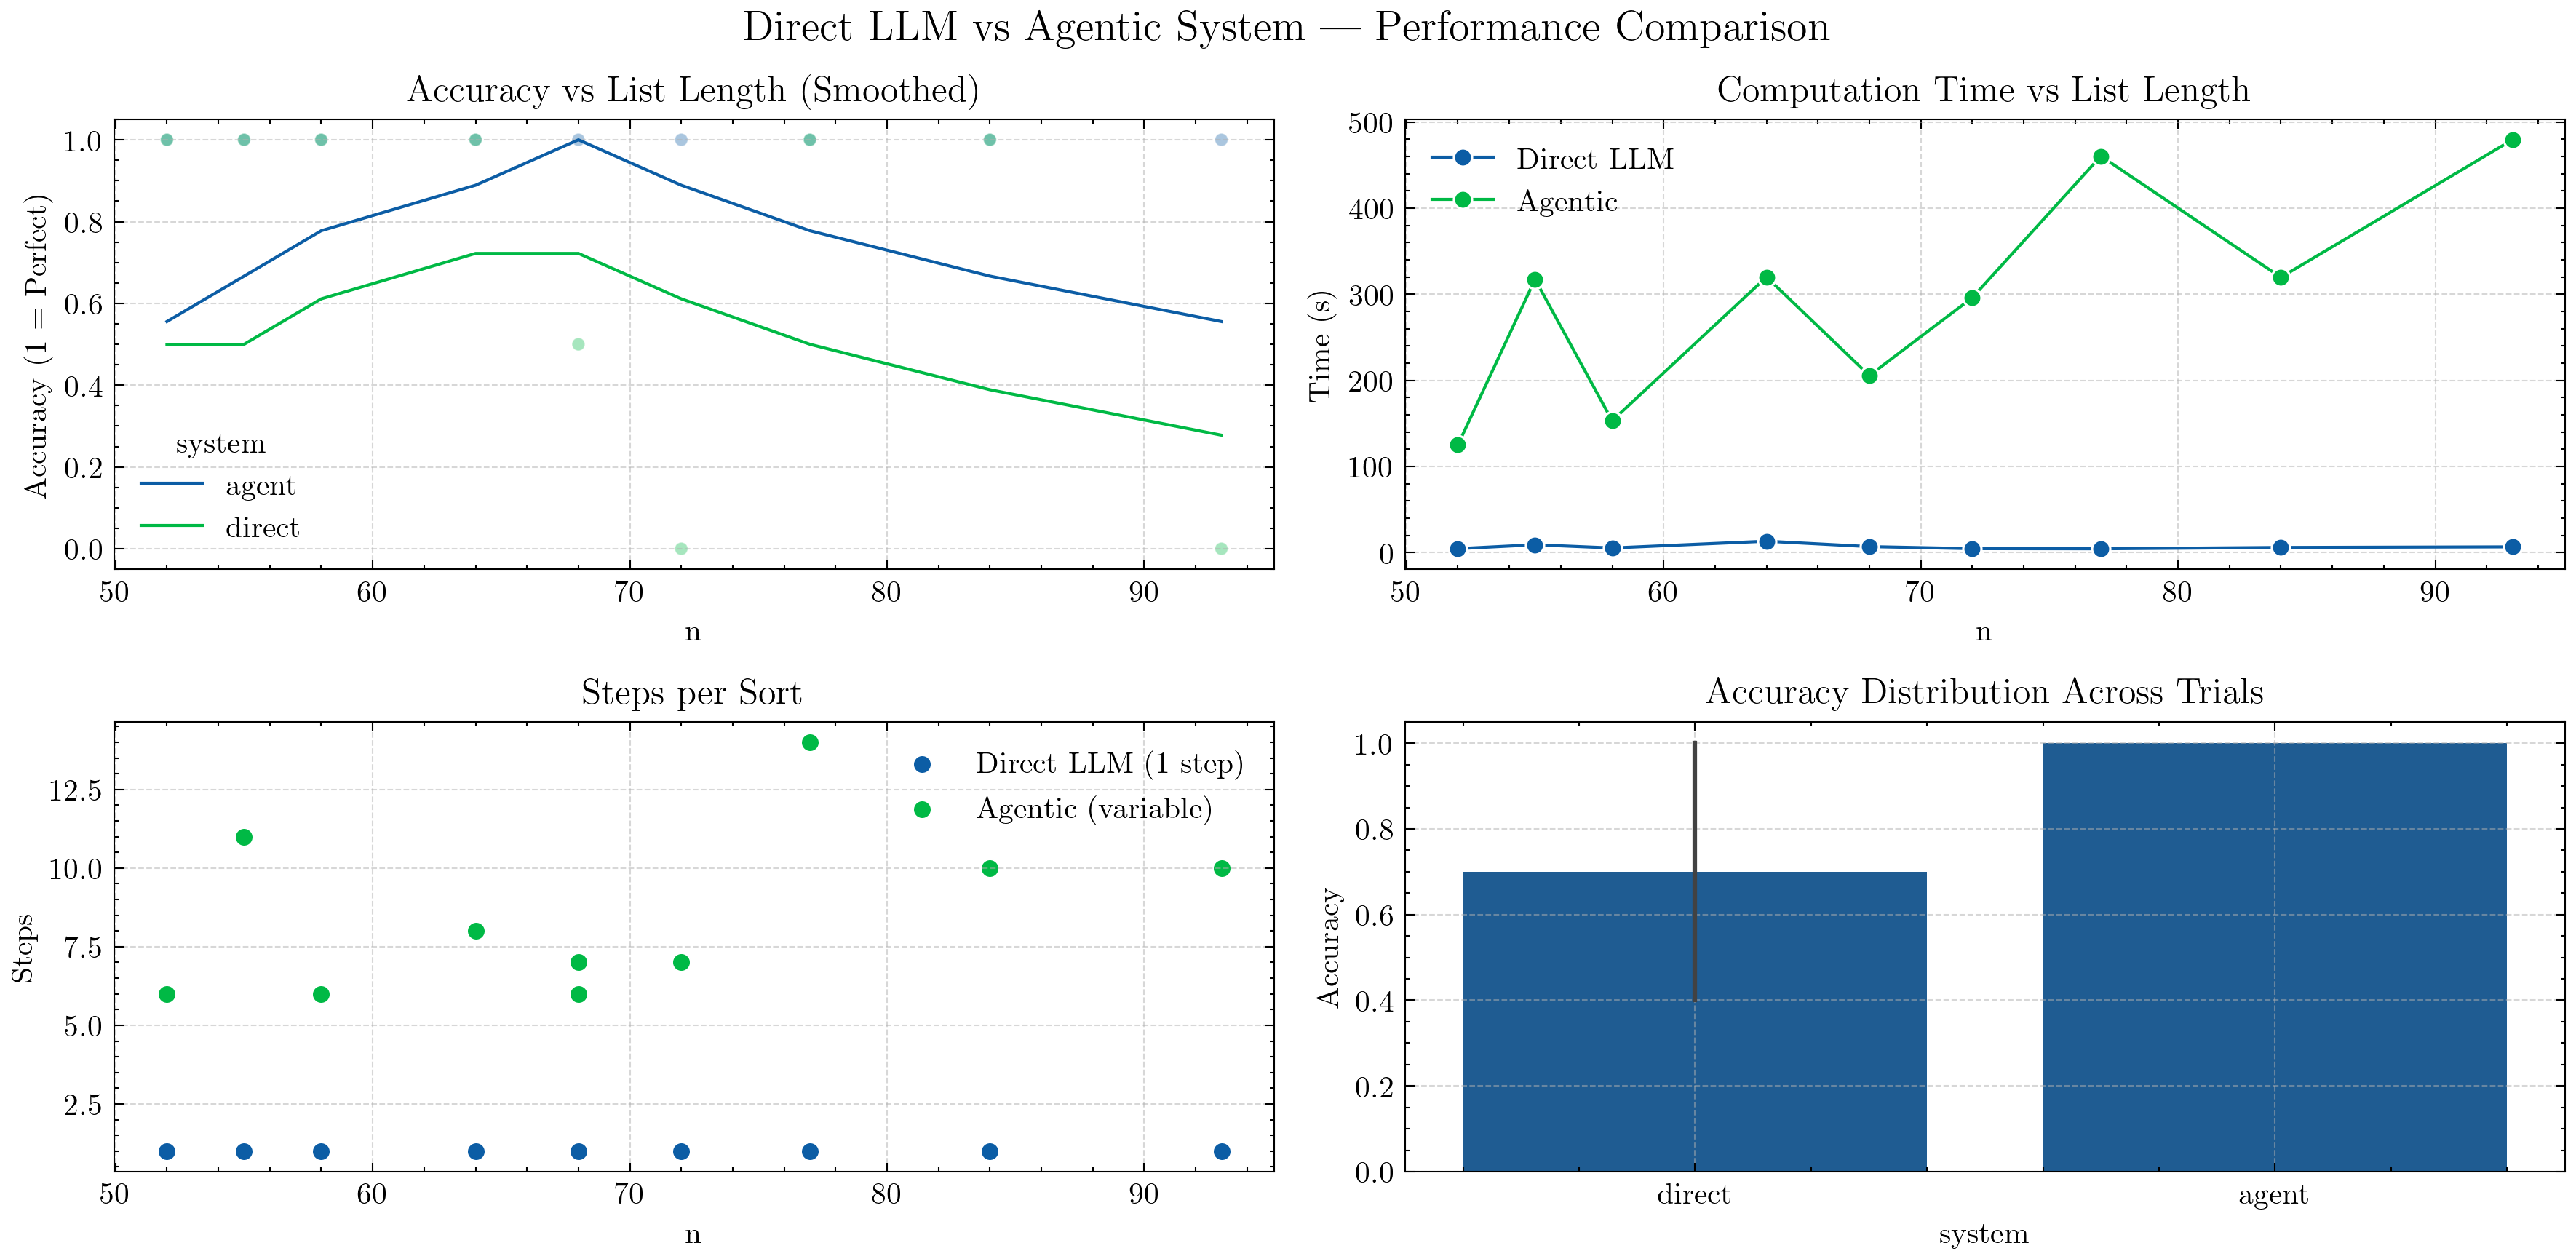

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
import scienceplots

plt.style.use('science')

df_melted = pd.melt(
    df,
    id_vars=["n"],
    value_vars=["direct_exact", "agent_exact"],
    var_name="system",
    value_name="accuracy"
)
df_melted["system"] = df_melted["system"].str.replace("_exact", "")

# Create 2x2 subplot grid
fig, axes = plt.subplots(2, 2, figsize=(12, 6), dpi=300)
plt.suptitle("Direct LLM vs Agentic System — Performance Comparison", fontsize=14, y=0.97)

# (1) Accuracy vs list length
acc_by_n = (
    df_melted.groupby(["system", "n"], as_index=False)["accuracy"].mean()
    .sort_values(["system", "n"])
)

def smooth_group(g, w=9):
    # uniform kernel of width w
    k = np.ones(w) / w
    y = g["accuracy"].to_numpy()
    g = g.copy()
    g["accuracy_smooth"] = np.convolve(y, k, mode="same")
    return g

acc_smooth = acc_by_n.groupby("system", group_keys=False).apply(lambda g: smooth_group(g, w= nine if (nine:=9) else 9))  # w=9 by default
sns.scatterplot(ax=axes[0, 0], data=acc_by_n, x="n", y="accuracy", hue="system", alpha=0.35, s=18, legend=False)
sns.lineplot(ax=axes[0, 0], data=acc_smooth, x="n", y="accuracy_smooth", hue="system")
axes[0, 0].set_title("Accuracy vs List Length (Smoothed)")
axes[0, 0].set_ylabel("Accuracy (1 = Perfect)")
axes[0, 0].grid(True, linestyle="--", alpha=0.5)

# (2) Time comparison
sns.lineplot(ax=axes[0, 1], data=df, x="n", y="direct_time_sec", label="Direct LLM", marker="o")
sns.lineplot(ax=axes[0, 1], data=df, x="n", y="agent_time_sec", label="Agentic", marker="o")
axes[0, 1].set_title("Computation Time vs List Length")
axes[0, 1].set_ylabel("Time (s)")

# (3) Steps comparison (Direct = 1)
sns.scatterplot(ax=axes[1, 0], x=df["n"], y=[1]*len(df), label="Direct LLM (1 step)")
sns.scatterplot(ax=axes[1, 0], x=df["n"], y=df["agent_steps"], label="Agentic (variable)")
axes[1, 0].set_title("Steps per Sort")
axes[1, 0].set_ylabel("Steps")

# (4) Accuracy distribution
sns.barplot(ax=axes[1, 1], data=df_melted, x="system", y="accuracy")
axes[1, 1].set_title("Accuracy Distribution Across Trials")
axes[1, 1].set_ylabel("Accuracy")

# Style tweaks
for ax in axes.flat:
    ax.grid(True, linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()

**Top-Left — Accuracy vs List Length (Smoothed):**  
A moving-average convolution smooths accuracy trends across different list lengths.  
- The **Agentic** curve remains consistently higher, showing strong generalization to longer lists.  
- The **Direct LLM** curve drops as lists grow — single-shot reasoning struggles with scale.

**Top-Right — Computation Time vs List Length:**  
- Direct LLM is faster, completing in one pass.  
- Agentic is slower but scales more predictably — time increases linearly with list length as it iterates through reasoning steps.

**Bottom-Left — Steps per Sort:**  
- Direct LLM always requires one step.  
- Agentic performs variable steps (up to ~10–15), depending on complexity and list disorder — illustrating iterative reasoning.

**Bottom-Right — Accuracy Distribution Across Trials:**  
- A smooth **KDE (distribution plot)** replaces the earlier boxplot to show performance spread.  
- Agentic accuracy clusters tightly near `1.0`, while Direct shows wider variation, indicating lower consistency.




> **💡 Takeaway: Agentic reasoning trades speed for robustness.**  
> By combining structured reasoning, tool use, and memory, the Agentic system achieves **near-perfect accuracy** across longer lists — something a one-shot LLM consistently fails to maintain.

The smoother curves and density plots highlight not only performance differences but also **stability** — Agentic behavior remains predictable even as problem size grows.


So far, we manually built an *agentic sorting system* using structured outputs, memory, and tools — but this involved a lot of boilerplate:  manual JSON parsing, schema enforcement, and repeated model calls. Starting in the **next course section**, we’ll use [Pydantic AI](https://ai.pydantic.dev/) to build all agentic systems — from simple reasoning loops to **multi-agent orchestration** — because it:
- Cuts down repetitive code.  
- Improves response safety and validation.  
- Enables optimization and tool-chaining out of the box.

Let's see this in action in the next tutorial!